# Bias Benchmark Analysis: Inverse Scaling Laws in VLMs

This notebook analyzes the results from bias benchmarks run on various Vision-Language Models (VLMs).
The key hypothesis is that **larger models exhibit more bias** - an "inverse scaling law" for bias.

## Benchmarks Analyzed:
- **VILP**: Visual Linguistic Priming benchmark
- **VILP without fact**: VILP variant without factual grounding
- **VLMs Are Biased**: Accuracy and bias ratio across different visual topics

## Models:
- Qwen2.5-VL (3B, 7B)
- InternVL3 (1B, 2B, 8B, 14B, 38B)

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re

# Set style for publication-quality plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Custom colors for model families
MODEL_FAMILY_COLORS = {
    'Qwen': '#E74C3C',  # Red
    'InternVL': '#3498DB'  # Blue
}

In [2]:
# Load the results
results_path = Path('overall_summary.json')
with open(results_path, 'r') as f:
    raw_results = json.load(f)

# Filter for successful runs only
results = [r for r in raw_results if r.get('status') == 'success']

print(f"Loaded {len(results)} successful results out of {len(raw_results)} total")
print(f"\nFailed runs:")
for r in raw_results:
    if r.get('status') == 'failed':
        print(f"  - {r['model']} on {r['task']}: {r.get('error', 'Unknown error')[:50]}...")

Loaded 24 successful results out of 24 total

Failed runs:


In [4]:
def extract_model_size(model_name: str) -> float:
    """Extract model size in billions from model name."""
    # Match patterns like '3B', '7B', '1B', '38B'
    match = re.search(r'(\d+\.?\d*)B', model_name)
    if match:
        return float(match.group(1))
    return None

def get_model_family(model_name: str) -> str:
    """Extract model family from model name."""
    if 'Qwen' in model_name:
        return 'Qwen'
    elif 'InternVL' in model_name:
        return 'InternVL'
    return 'Other'

def get_short_name(model_name: str) -> str:
    """Get a short display name for the model."""
    return model_name.split('/')[-1]

# Create a DataFrame with processed data
df_list = []
for r in results:
    row = {
        'model': r['model'],
        'model_short': get_short_name(r['model']),
        'model_family': get_model_family(r['model']),
        'model_size_b': extract_model_size(r['model']),
        'task': r['task'],
    }
    
    # Add task-specific metrics
    for key, value in r.items():
        if key not in ['model', 'task', 'status', 'alias'] and not key.endswith('_stderr,none'):
            if isinstance(value, (int, float)):
                clean_key = key.replace(',none', '')
                row[clean_key] = value
            elif isinstance(value, dict):  # accuracy_by_topic
                for topic, score in value.items():
                    if topic != 'overall':
                        row[f'topic_{topic}'] = score
    
    df_list.append(row)

df = pd.DataFrame(df_list)
print(f"DataFrame shape: {df.shape}")
df.head(24)

DataFrame shape: (24, 16)


,model,model_short,model_family,model_size_b,task,vilp_score,vilp_prior,accuracy,bias_ratio,topic_Optical Illusion,topic_Game Boards,topic_Patterned Grid,topic_Chess Pieces,topic_Logos,topic_Flags,topic_Animals
0,Qwen/Qwen2.5-VL-3B-Instruct,Qwen2.5-VL-3B-Instruct,Qwen,3.0,vilp,0.541667,0.820000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Qwen/Qwen2.5-VL-3B-Instruct,Qwen2.5-VL-3B-Instruct,Qwen,3.0,vilp_without_fact,0.501667,0.740000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Qwen/Qwen2.5-VL-3B-Instruct,Qwen2.5-VL-3B-Instruct,Qwen,3.0,vlms_are_biased,NaN,NaN,0.198635,0.512931,0.501263,0.119048,0.139881,0.000000,0.079710,0.233333,0.000000
3,Qwen/Qwen2.5-VL-7B-Instruct,Qwen2.5-VL-7B-Instruct,Qwen,7.0,vilp,0.546667,0.873333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Qwen/Qwen2.5-VL-7B-Instruct,Qwen2.5-VL-7B-Instruct,Qwen,7.0,vilp_without_fact,0.515000,0.826667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Qwen/Qwen2.5-VL-7B-Instruct,Qwen2.5-VL-7B-Instruct,Qwen,7.0,vlms_are_biased,NaN,NaN,0.229885,0.595546,0.574495,0.083333,0.142857,0.000000,0.103865,0.320833,0.005495
6,OpenGVLab/InternVL3-1B,InternVL3-1B,InternVL,1.0,vilp,0.341667,0.543333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,OpenGVLab/InternVL3-1B,InternVL3-1B,InternVL,1.0,vilp_without_fact,0.381667,0.486667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,OpenGVLab/InternVL3-1B,InternVL3-1B,InternVL,1.0,vlms_are_biased,NaN,NaN,0.191810,0.470905,0.544192,0.136905,0.062500,0.000000,0.009662,0.220833,0.003663
9,OpenGVLab/InternVL3-2B,InternVL3-2B,InternVL,2.0,vilp,0.591667,0.650000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1. Individual Benchmark Results

Let's visualize each benchmark separately to understand the inverse scaling relationship.

In [5]:
# Split data by task
df_vilp = df[df['task'] == 'vilp'].copy()
df_vilp_nofact = df[df['task'] == 'vilp_without_fact'].copy()
df_vlms_biased = df[df['task'] == 'vlms_are_biased'].copy()

print(f"VILP: {len(df_vilp)} models")
print(f"VILP without fact: {len(df_vilp_nofact)} models")
print(f"VLMs are Biased: {len(df_vlms_biased)} models")

VILP: 8 models
VILP without fact: 8 models
VLMs are Biased: 8 models


### 1.1 VILP Benchmark

**Key observation**: VILP shows **no capability scaling** (score stays flat) but **prior bias scaling** (larger models have higher prior scores, indicating stronger reliance on learned priors rather than visual evidence).

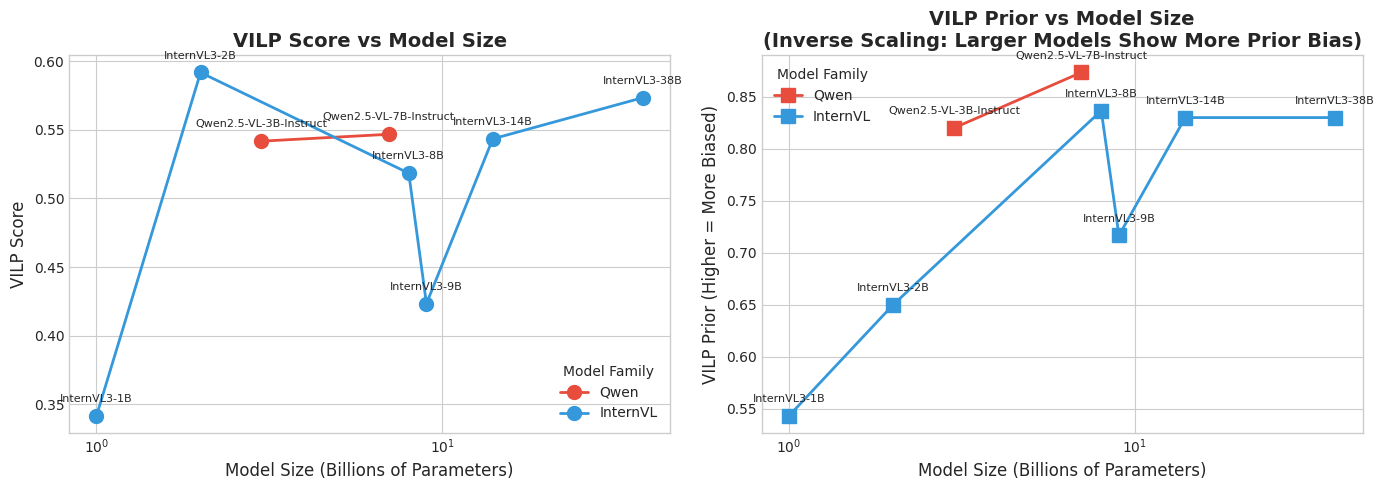

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# VILP Score vs Model Size
ax1 = axes[0]
for family in df_vilp['model_family'].unique():
    subset = df_vilp[df_vilp['model_family'] == family].sort_values('model_size_b')
    ax1.plot(subset['model_size_b'], subset['vilp_score'], 
             marker='o', markersize=10, linewidth=2,
             label=family, color=MODEL_FAMILY_COLORS.get(family, 'gray'))
    # Add model labels
    for _, row in subset.iterrows():
        ax1.annotate(row['model_short'], (row['model_size_b'], row['vilp_score']),
                    textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

ax1.set_xlabel('Model Size (Billions of Parameters)', fontsize=12)
ax1.set_ylabel('VILP Score', fontsize=12)
ax1.set_title('VILP Score vs Model Size\n(No Capability Scaling: Score Stays Flat)', fontsize=14, fontweight='bold')
ax1.legend(title='Model Family')
ax1.set_xscale('log')

# VILP Prior vs Model Size
ax2 = axes[1]
for family in df_vilp['model_family'].unique():
    subset = df_vilp[df_vilp['model_family'] == family].sort_values('model_size_b')
    ax2.plot(subset['model_size_b'], subset['vilp_prior'], 
             marker='s', markersize=10, linewidth=2,
             label=family, color=MODEL_FAMILY_COLORS.get(family, 'gray'))
    for _, row in subset.iterrows():
        ax2.annotate(row['model_short'], (row['model_size_b'], row['vilp_prior']),
                    textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

ax2.set_xlabel('Model Size (Billions of Parameters)', fontsize=12)
ax2.set_ylabel('VILP Prior (Higher = Stronger Prior Reliance)', fontsize=12)
ax2.set_title('VILP Prior vs Model Size\n(Prior Bias Scaling: Larger Models Rely More on Priors)', 
              fontsize=14, fontweight='bold')
ax2.legend(title='Model Family')
ax2.set_xscale('log')

plt.tight_layout()
plt.savefig('vilp_benchmark.png', dpi=150, bbox_inches='tight')
plt.show()

### 1.2 VILP Without Fact Benchmark

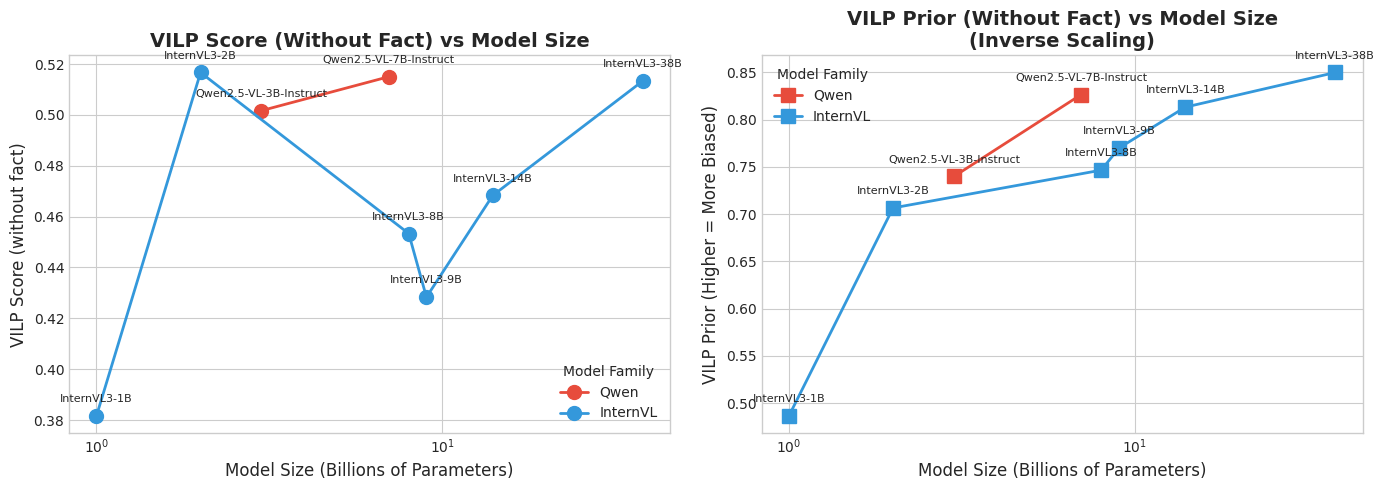

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# VILP Score (without fact) vs Model Size
ax1 = axes[0]
for family in df_vilp_nofact['model_family'].unique():
    subset = df_vilp_nofact[df_vilp_nofact['model_family'] == family].sort_values('model_size_b')
    ax1.plot(subset['model_size_b'], subset['vilp_score'], 
             marker='o', markersize=10, linewidth=2,
             label=family, color=MODEL_FAMILY_COLORS.get(family, 'gray'))
    for _, row in subset.iterrows():
        ax1.annotate(row['model_short'], (row['model_size_b'], row['vilp_score']),
                    textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

ax1.set_xlabel('Model Size (Billions of Parameters)', fontsize=12)
ax1.set_ylabel('VILP Score (without fact)', fontsize=12)
ax1.set_title('VILP Score (Without Fact) vs Model Size', fontsize=14, fontweight='bold')
ax1.legend(title='Model Family')
ax1.set_xscale('log')

# VILP Prior (without fact) vs Model Size
ax2 = axes[1]
for family in df_vilp_nofact['model_family'].unique():
    subset = df_vilp_nofact[df_vilp_nofact['model_family'] == family].sort_values('model_size_b')
    ax2.plot(subset['model_size_b'], subset['vilp_prior'], 
             marker='s', markersize=10, linewidth=2,
             label=family, color=MODEL_FAMILY_COLORS.get(family, 'gray'))
    for _, row in subset.iterrows():
        ax2.annotate(row['model_short'], (row['model_size_b'], row['vilp_prior']),
                    textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

ax2.set_xlabel('Model Size (Billions of Parameters)', fontsize=12)
ax2.set_ylabel('VILP Prior (Higher = More Biased)', fontsize=12)
ax2.set_title('VILP Prior (Without Fact) vs Model Size\n(Inverse Scaling)', 
              fontsize=14, fontweight='bold')
ax2.legend(title='Model Family')
ax2.set_xscale('log')

plt.tight_layout()
plt.savefig('vilp_without_fact_benchmark.png', dpi=150, bbox_inches='tight')
plt.show()

### 1.3 VLMs Are Biased Benchmark

**Key observation**: This benchmark shows clear **inverse scaling** - larger models have lower accuracy and higher bias ratios. The 38B model performs worst.

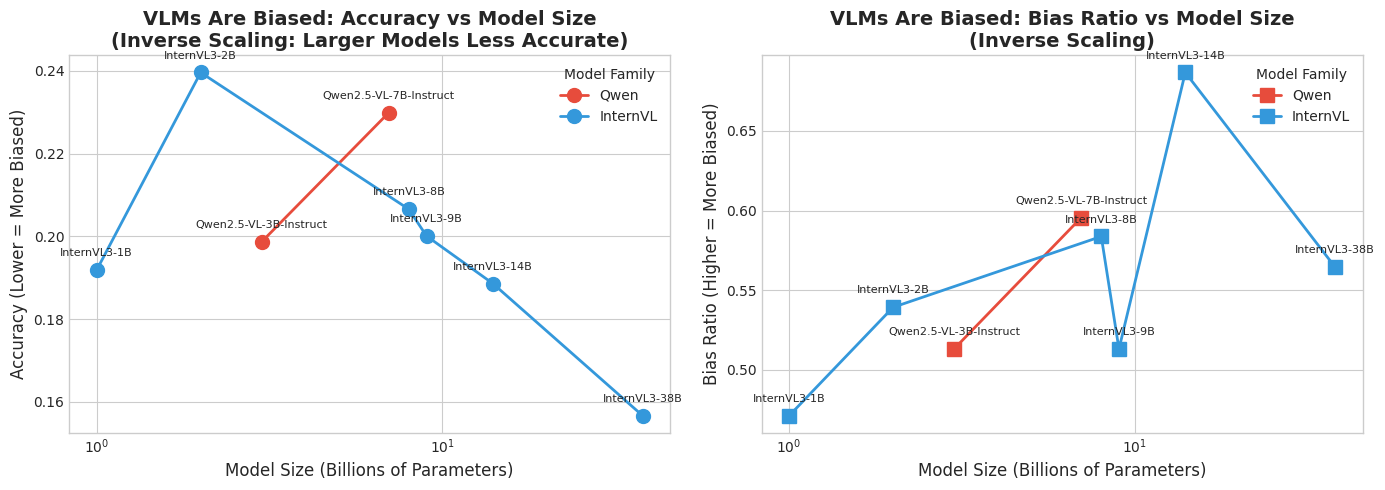

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy vs Model Size (lower = more biased)
ax1 = axes[0]
for family in df_vlms_biased['model_family'].unique():
    subset = df_vlms_biased[df_vlms_biased['model_family'] == family].sort_values('model_size_b')
    ax1.plot(subset['model_size_b'], subset['accuracy'], 
             marker='o', markersize=10, linewidth=2,
             label=family, color=MODEL_FAMILY_COLORS.get(family, 'gray'))
    for _, row in subset.iterrows():
        ax1.annotate(row['model_short'], (row['model_size_b'], row['accuracy']),
                    textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

ax1.set_xlabel('Model Size (Billions of Parameters)', fontsize=12)
ax1.set_ylabel('Accuracy (Lower = More Biased)', fontsize=12)
ax1.set_title('VLMs Are Biased: Accuracy vs Model Size\n(Inverse Scaling: Larger Models Less Accurate)', 
              fontsize=14, fontweight='bold')
ax1.legend(title='Model Family')
ax1.set_xscale('log')

# Bias Ratio vs Model Size (higher = more biased)
ax2 = axes[1]
for family in df_vlms_biased['model_family'].unique():
    subset = df_vlms_biased[df_vlms_biased['model_family'] == family].sort_values('model_size_b')
    ax2.plot(subset['model_size_b'], subset['bias_ratio'], 
             marker='s', markersize=10, linewidth=2,
             label=family, color=MODEL_FAMILY_COLORS.get(family, 'gray'))
    for _, row in subset.iterrows():
        ax2.annotate(row['model_short'], (row['model_size_b'], row['bias_ratio']),
                    textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

ax2.set_xlabel('Model Size (Billions of Parameters)', fontsize=12)
ax2.set_ylabel('Bias Ratio (Higher = More Biased)', fontsize=12)
ax2.set_title('VLMs Are Biased: Bias Ratio vs Model Size\n(Inverse Scaling)', 
              fontsize=14, fontweight='bold')
ax2.legend(title='Model Family')
ax2.set_xscale('log')

plt.tight_layout()
plt.savefig('vlms_are_biased_benchmark.png', dpi=150, bbox_inches='tight')
plt.show()

## 2. Combined VILP Analysis

Compare VILP with and without factual context.

In [9]:
# Merge VILP data for comparison
vilp_combined = df_vilp[['model', 'model_short', 'model_family', 'model_size_b', 'vilp_score', 'vilp_prior']].copy()
vilp_combined = vilp_combined.rename(columns={'vilp_score': 'vilp_score_with_fact', 'vilp_prior': 'vilp_prior_with_fact'})

vilp_nofact_metrics = df_vilp_nofact[['model', 'vilp_score', 'vilp_prior']].copy()
vilp_nofact_metrics = vilp_nofact_metrics.rename(columns={'vilp_score': 'vilp_score_no_fact', 'vilp_prior': 'vilp_prior_no_fact'})

vilp_combined = vilp_combined.merge(vilp_nofact_metrics, on='model')
vilp_combined = vilp_combined.sort_values('model_size_b')

print(vilp_combined)

                         model             model_short model_family  \
2       OpenGVLab/InternVL3-1B            InternVL3-1B     InternVL   
3       OpenGVLab/InternVL3-2B            InternVL3-2B     InternVL   
0  Qwen/Qwen2.5-VL-3B-Instruct  Qwen2.5-VL-3B-Instruct         Qwen   
1  Qwen/Qwen2.5-VL-7B-Instruct  Qwen2.5-VL-7B-Instruct         Qwen   
4       OpenGVLab/InternVL3-8B            InternVL3-8B     InternVL   
5       OpenGVLab/InternVL3-9B            InternVL3-9B     InternVL   
6      OpenGVLab/InternVL3-14B           InternVL3-14B     InternVL   
7      OpenGVLab/InternVL3-38B           InternVL3-38B     InternVL   

   model_size_b  vilp_score_with_fact  vilp_prior_with_fact  \
2           1.0              0.341667              0.543333   
3           2.0              0.591667              0.650000   
0           3.0              0.541667              0.820000   
1           7.0              0.546667              0.873333   
4           8.0              0.518333        

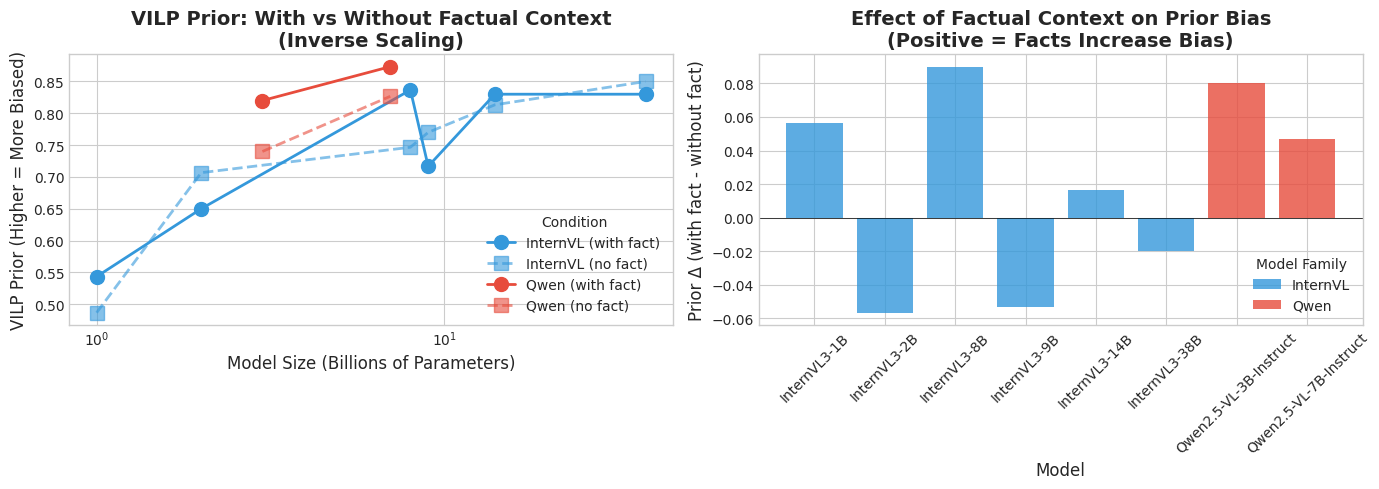

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# VILP Prior comparison (with vs without fact)
ax1 = axes[0]
for family in vilp_combined['model_family'].unique():
    subset = vilp_combined[vilp_combined['model_family'] == family].sort_values('model_size_b')
    color = MODEL_FAMILY_COLORS.get(family, 'gray')
    
    ax1.plot(subset['model_size_b'], subset['vilp_prior_with_fact'], 
             marker='o', markersize=10, linewidth=2, linestyle='-',
             label=f'{family} (with fact)', color=color)
    ax1.plot(subset['model_size_b'], subset['vilp_prior_no_fact'], 
             marker='s', markersize=10, linewidth=2, linestyle='--',
             label=f'{family} (no fact)', color=color, alpha=0.6)

ax1.set_xlabel('Model Size (Billions of Parameters)', fontsize=12)
ax1.set_ylabel('VILP Prior (Higher = More Biased)', fontsize=12)
ax1.set_title('VILP Prior: With vs Without Factual Context\n(Inverse Scaling)', 
              fontsize=14, fontweight='bold')
ax1.legend(title='Condition', loc='lower right')
ax1.set_xscale('log')

# Delta between with fact and without fact
ax2 = axes[1]
vilp_combined['prior_delta'] = vilp_combined['vilp_prior_with_fact'] - vilp_combined['vilp_prior_no_fact']

for family in vilp_combined['model_family'].unique():
    subset = vilp_combined[vilp_combined['model_family'] == family].sort_values('model_size_b')
    ax2.bar([get_short_name(m) for m in subset['model']], subset['prior_delta'],
            color=MODEL_FAMILY_COLORS.get(family, 'gray'), alpha=0.8, label=family)

ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.set_xlabel('Model', fontsize=12)
ax2.set_ylabel('Prior Δ (with fact - without fact)', fontsize=12)
ax2.set_title('Effect of Factual Context on Prior Bias\n(Positive = Facts Increase Bias)', 
              fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.legend(title='Model Family')

plt.tight_layout()
plt.savefig('vilp_combined_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Combined Overview: All Benchmarks

A comprehensive view showing all metrics across model sizes.

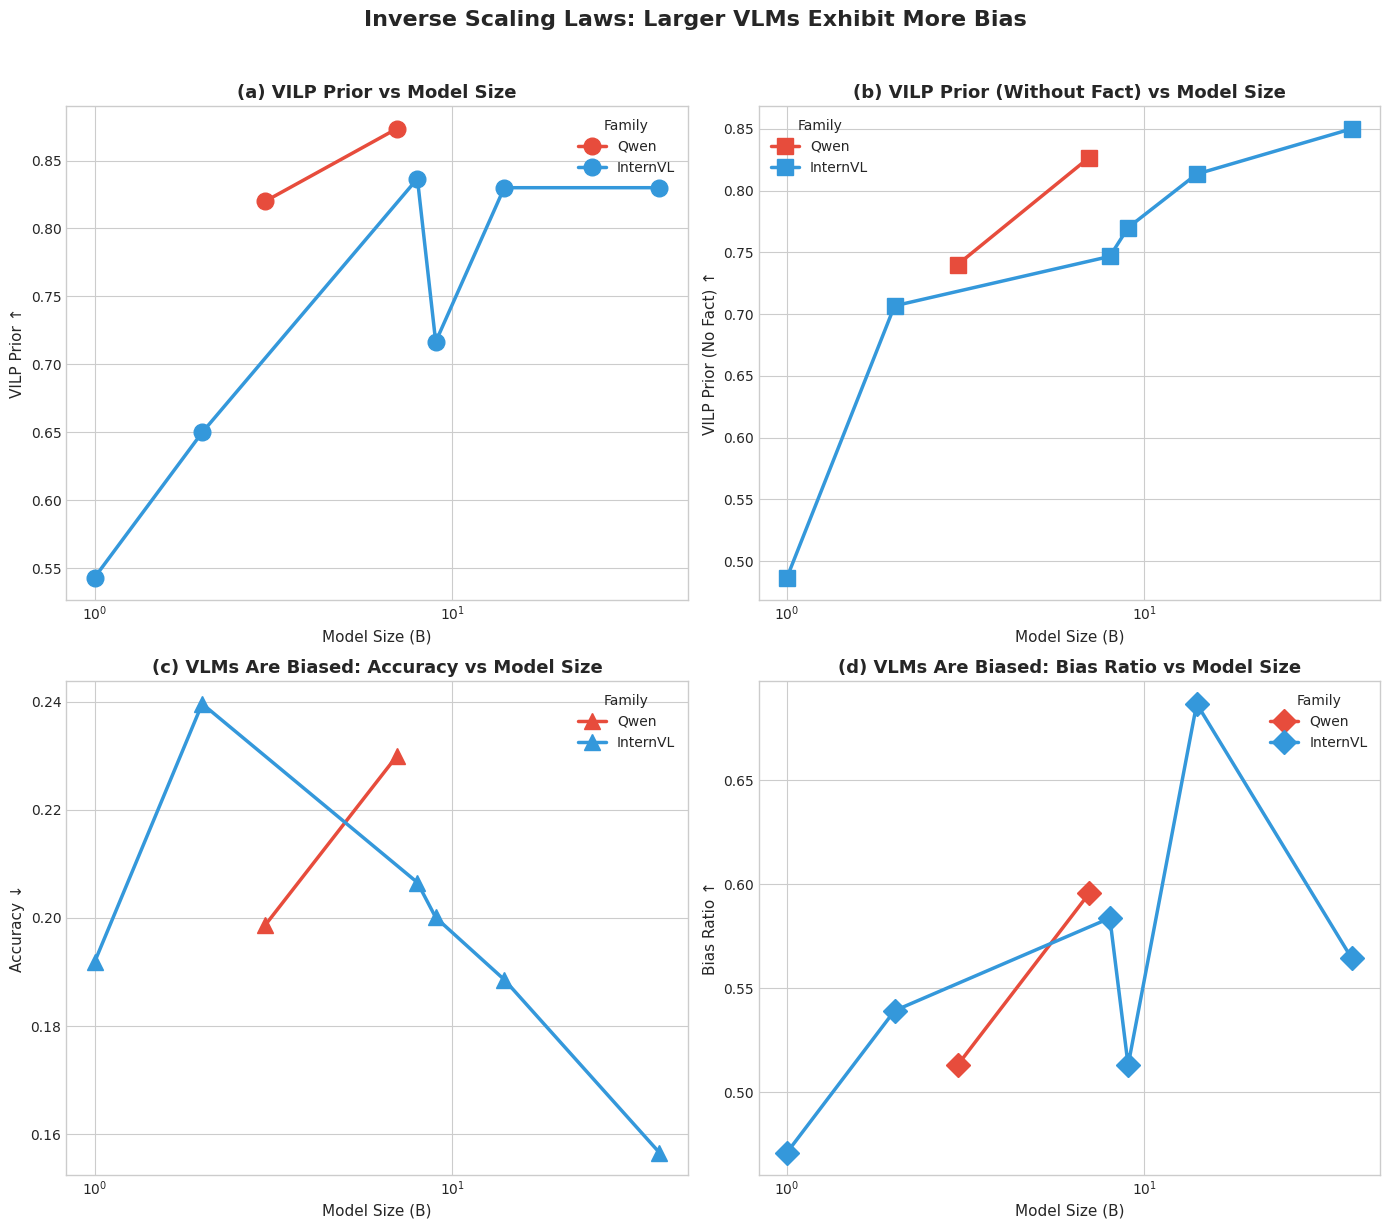

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. VILP Score (no scaling)
ax1 = axes[0, 0]
for family in df_vilp['model_family'].unique():
    subset = df_vilp[df_vilp['model_family'] == family].sort_values('model_size_b')
    ax1.plot(subset['model_size_b'], subset['vilp_score'], 
             marker='o', markersize=12, linewidth=2.5,
             label=family, color=MODEL_FAMILY_COLORS.get(family, 'gray'))

ax1.set_xlabel('Model Size (B)', fontsize=11)
ax1.set_ylabel('VILP Score', fontsize=11)
ax1.set_title('(a) VILP Score: No Capability Scaling', fontsize=13, fontweight='bold')
ax1.legend(title='Family')
ax1.set_xscale('log')

# 2. VILP Prior (prior bias scaling)
ax2 = axes[0, 1]
for family in df_vilp['model_family'].unique():
    subset = df_vilp[df_vilp['model_family'] == family].sort_values('model_size_b')
    ax2.plot(subset['model_size_b'], subset['vilp_prior'], 
             marker='s', markersize=12, linewidth=2.5,
             label=family, color=MODEL_FAMILY_COLORS.get(family, 'gray'))

ax2.set_xlabel('Model Size (B)', fontsize=11)
ax2.set_ylabel('VILP Prior ↑', fontsize=11)
ax2.set_title('(b) VILP Prior: Prior Bias Scaling', fontsize=13, fontweight='bold')
ax2.legend(title='Family')
ax2.set_xscale('log')

# 3. VLMs Are Biased - Accuracy (inverse scaling)
ax3 = axes[1, 0]
for family in df_vlms_biased['model_family'].unique():
    subset = df_vlms_biased[df_vlms_biased['model_family'] == family].sort_values('model_size_b')
    ax3.plot(subset['model_size_b'], subset['accuracy'], 
             marker='^', markersize=12, linewidth=2.5,
             label=family, color=MODEL_FAMILY_COLORS.get(family, 'gray'))

ax3.set_xlabel('Model Size (B)', fontsize=11)
ax3.set_ylabel('Accuracy ↓', fontsize=11)
ax3.set_title('(c) VLMs Are Biased: Inverse Scaling', fontsize=13, fontweight='bold')
ax3.legend(title='Family')
ax3.set_xscale('log')

# 4. VLMs Are Biased - Bias Ratio (inverse scaling)
ax4 = axes[1, 1]
for family in df_vlms_biased['model_family'].unique():
    subset = df_vlms_biased[df_vlms_biased['model_family'] == family].sort_values('model_size_b')
    ax4.plot(subset['model_size_b'], subset['bias_ratio'], 
             marker='D', markersize=12, linewidth=2.5,
             label=family, color=MODEL_FAMILY_COLORS.get(family, 'gray'))

ax4.set_xlabel('Model Size (B)', fontsize=11)
ax4.set_ylabel('Bias Ratio ↑', fontsize=11)
ax4.set_title('(d) VLMs Are Biased: Bias Ratio Scaling', fontsize=13, fontweight='bold')
ax4.legend(title='Family')
ax4.set_xscale('log')

plt.suptitle('Scaling Patterns in VLM Bias Benchmarks', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('combined_benchmark_overview.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Topic-Level Analysis (VLMs Are Biased)

Explore accuracy breakdown by visual topic.

In [12]:
# Extract topic-level data
topic_cols = [col for col in df_vlms_biased.columns if col.startswith('topic_')]
topics = [col.replace('topic_', '') for col in topic_cols]

print(f"Topics analyzed: {topics}")

# Create topic dataframe
topic_data = []
for _, row in df_vlms_biased.iterrows():
    for topic_col in topic_cols:
        topic = topic_col.replace('topic_', '')
        if pd.notna(row[topic_col]):
            topic_data.append({
                'model': row['model_short'],
                'model_size_b': row['model_size_b'],
                'model_family': row['model_family'],
                'topic': topic,
                'accuracy': row[topic_col]
            })

df_topics = pd.DataFrame(topic_data)
df_topics.head()

Topics analyzed: ['Optical Illusion', 'Game Boards', 'Patterned Grid', 'Chess Pieces', 'Logos', 'Flags', 'Animals']


,model,model_size_b,model_family,topic,accuracy
0,Qwen2.5-VL-3B-Instruct,3.0,Qwen,Optical Illusion,0.501263
1,Qwen2.5-VL-3B-Instruct,3.0,Qwen,Game Boards,0.119048
2,Qwen2.5-VL-3B-Instruct,3.0,Qwen,Patterned Grid,0.139881
3,Qwen2.5-VL-3B-Instruct,3.0,Qwen,Chess Pieces,0.000000
4,Qwen2.5-VL-3B-Instruct,3.0,Qwen,Logos,0.079710


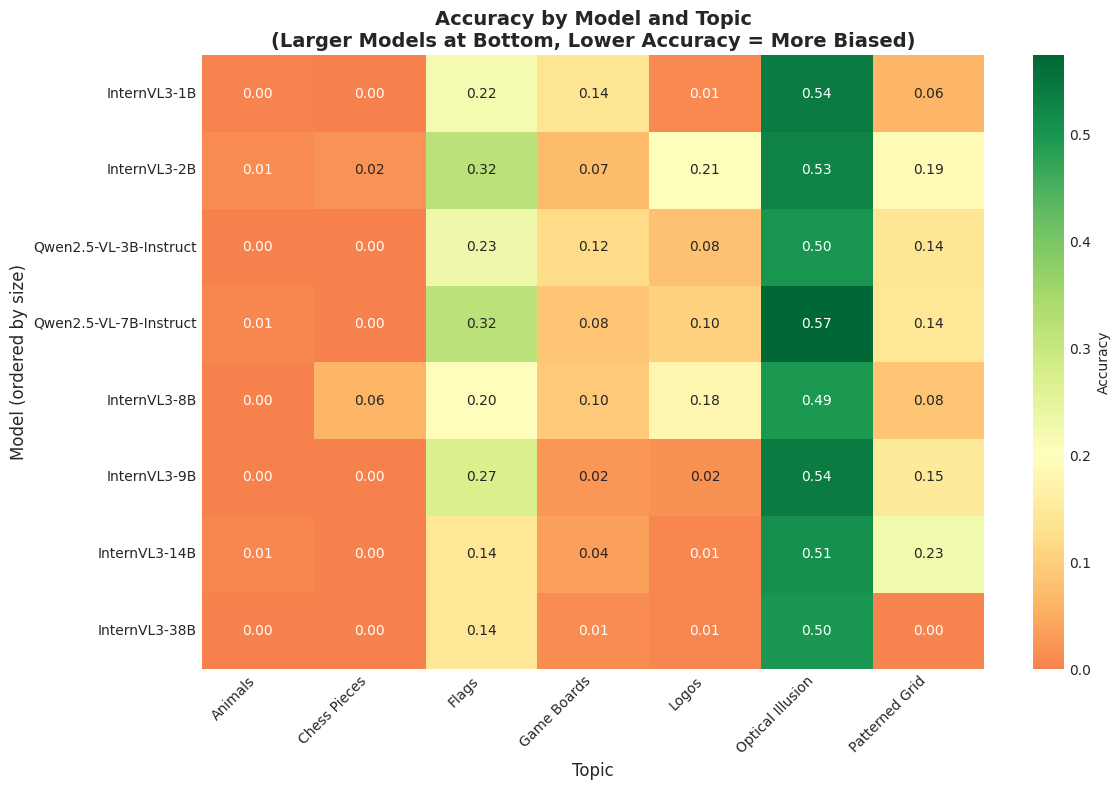

In [13]:
# Heatmap of accuracy by model and topic
pivot_data = df_topics.pivot_table(values='accuracy', index='model', columns='topic', aggfunc='mean')

# Sort by model size
model_order = df_vlms_biased.sort_values('model_size_b')['model_short'].tolist()
pivot_data = pivot_data.reindex(model_order)

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(pivot_data, annot=True, fmt='.2f', cmap='RdYlGn', 
            center=0.2, ax=ax, cbar_kws={'label': 'Accuracy'})
ax.set_title('Accuracy by Model and Topic\n(Larger Models at Bottom, Lower Accuracy = More Biased)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Topic', fontsize=12)
ax.set_ylabel('Model (ordered by size)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('topic_accuracy_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

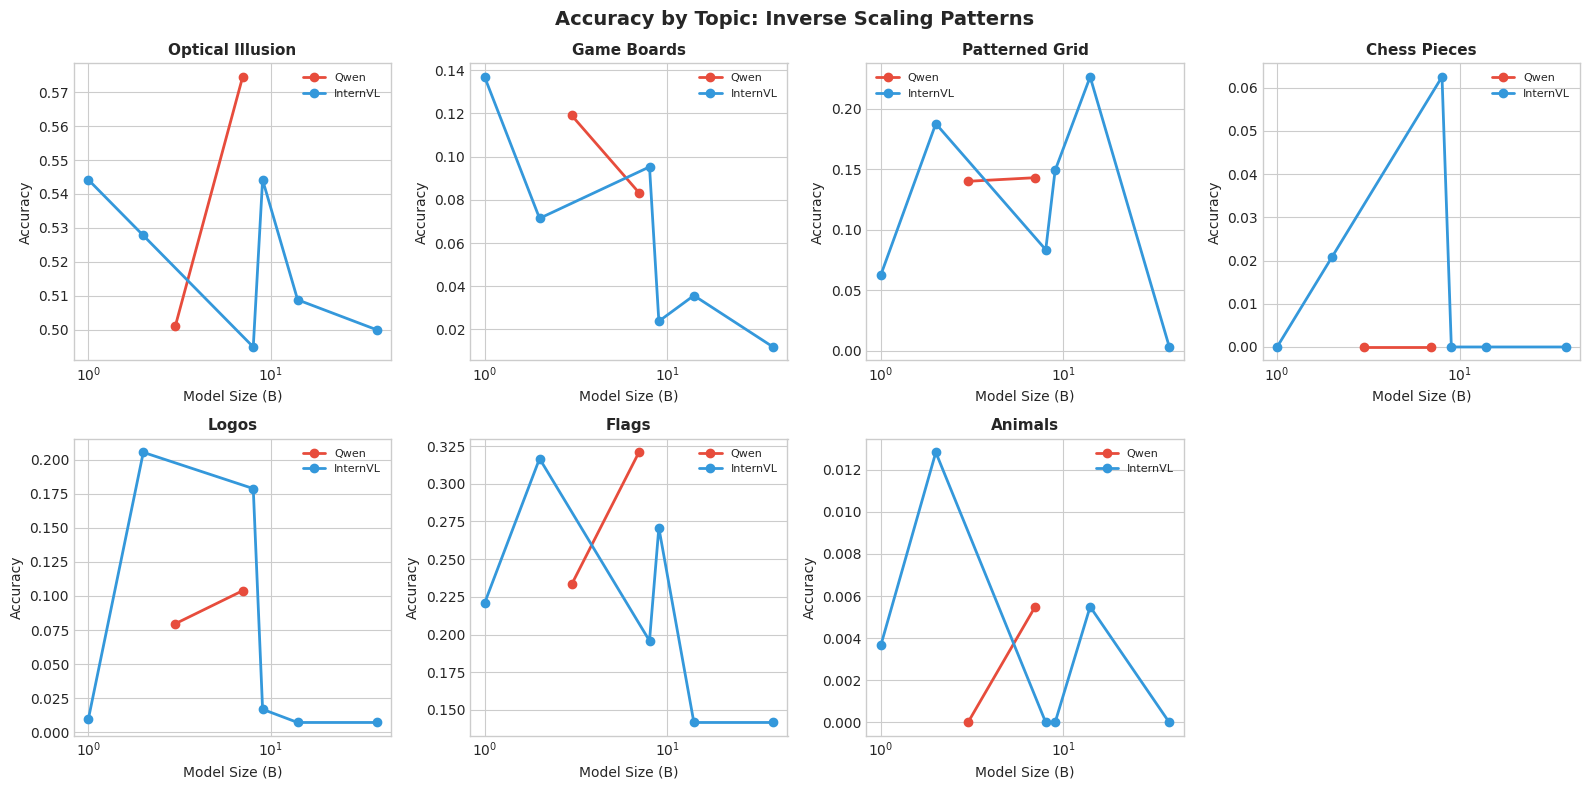

In [15]:
# Topic-wise inverse scaling visualization
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, topic in enumerate(topics[:7]):
    ax = axes[idx]
    topic_subset = df_topics[df_topics['topic'] == topic]
    
    for family in topic_subset['model_family'].unique():
        family_data = topic_subset[topic_subset['model_family'] == family].sort_values('model_size_b')
        ax.plot(family_data['model_size_b'], family_data['accuracy'],
               marker='o', linewidth=2, label=family,
               color=MODEL_FAMILY_COLORS.get(family, 'gray'))
    
    ax.set_xlabel('Model Size (B)')
    ax.set_ylabel('Accuracy')
    ax.set_title(topic, fontsize=11, fontweight='bold')
    ax.set_xscale('log')
    ax.legend(fontsize=8)

# Hide unused subplot
axes[-1].axis('off')

plt.suptitle('Accuracy by Topic: Inverse Scaling Patterns', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('topic_inverse_scaling.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Correlation Analysis

Statistical analysis of the inverse scaling relationship.

In [16]:
from scipy import stats

# Calculate correlations between model size and bias metrics
correlations = []

# VILP Prior
r, p = stats.spearmanr(df_vilp['model_size_b'], df_vilp['vilp_prior'])
correlations.append({'Metric': 'VILP Prior', 'Spearman r': r, 'p-value': p, 'Direction': 'Higher = More Biased'})

# VILP Prior (no fact)
r, p = stats.spearmanr(df_vilp_nofact['model_size_b'], df_vilp_nofact['vilp_prior'])
correlations.append({'Metric': 'VILP Prior (No Fact)', 'Spearman r': r, 'p-value': p, 'Direction': 'Higher = More Biased'})

# VLMs Are Biased - Accuracy
r, p = stats.spearmanr(df_vlms_biased['model_size_b'], df_vlms_biased['accuracy'])
correlations.append({'Metric': 'VLMs Biased Accuracy', 'Spearman r': r, 'p-value': p, 'Direction': 'Lower = More Biased'})

# VLMs Are Biased - Bias Ratio
r, p = stats.spearmanr(df_vlms_biased['model_size_b'], df_vlms_biased['bias_ratio'])
correlations.append({'Metric': 'VLMs Biased Bias Ratio', 'Spearman r': r, 'p-value': p, 'Direction': 'Higher = More Biased'})

corr_df = pd.DataFrame(correlations)
corr_df['Significant (p<0.05)'] = corr_df['p-value'] < 0.05
print("\n=== Inverse Scaling Correlations (Model Size vs Bias Metrics) ===")
print(corr_df.to_string(index=False))


=== Inverse Scaling Correlations (Model Size vs Bias Metrics) ===
                Metric  Spearman r  p-value            Direction  Significant (p<0.05)
            VILP Prior    0.538932 0.168118 Higher = More Biased                 False
  VILP Prior (No Fact)    0.857143 0.006530 Higher = More Biased                  True
  VLMs Biased Accuracy   -0.500000 0.207031  Lower = More Biased                 False
VLMs Biased Bias Ratio    0.562884 0.146332 Higher = More Biased                 False


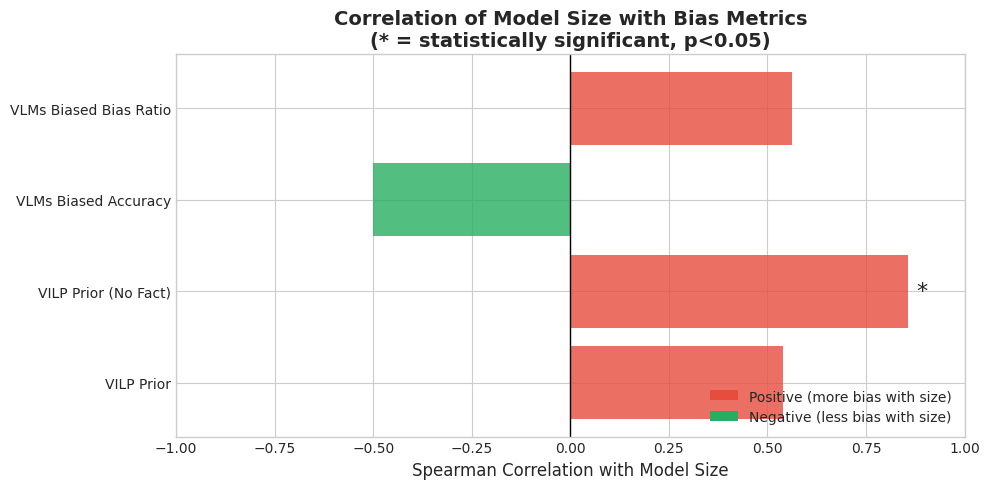

In [17]:
# Visualization of correlations
fig, ax = plt.subplots(figsize=(10, 5))

colors = ['#E74C3C' if r > 0 else '#27AE60' for r in corr_df['Spearman r']]
bars = ax.barh(corr_df['Metric'], corr_df['Spearman r'], color=colors, alpha=0.8)

# Add significance markers
for i, (_, row) in enumerate(corr_df.iterrows()):
    if row['Significant (p<0.05)']:
        ax.text(row['Spearman r'] + 0.02, i, '*', fontsize=16, va='center')

ax.axvline(x=0, color='black', linewidth=1)
ax.set_xlabel('Spearman Correlation with Model Size', fontsize=12)
ax.set_title('Correlation of Model Size with Bias Metrics\n(* = statistically significant, p<0.05)', 
             fontsize=14, fontweight='bold')
ax.set_xlim(-1, 1)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#E74C3C', label='Positive (more bias with size)'),
                   Patch(facecolor='#27AE60', label='Negative (less bias with size)')]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('correlation_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Model Family Comparison

Compare bias patterns between Qwen and InternVL model families.

In [18]:
# Aggregate metrics by model family
family_stats = df.groupby('model_family').agg({
    'model_size_b': ['min', 'max', 'mean'],
}).round(2)
family_stats.columns = ['_'.join(col) for col in family_stats.columns]

# Add mean metrics per family for each task
for task_name, task_df in [('vilp', df_vilp), ('vilp_nofact', df_vilp_nofact), ('vlms_biased', df_vlms_biased)]:
    if 'vilp_prior' in task_df.columns:
        means = task_df.groupby('model_family')['vilp_prior'].mean()
        family_stats[f'{task_name}_prior_mean'] = means
    if 'accuracy' in task_df.columns:
        means = task_df.groupby('model_family')['accuracy'].mean()
        family_stats[f'{task_name}_accuracy_mean'] = means
    if 'bias_ratio' in task_df.columns:
        means = task_df.groupby('model_family')['bias_ratio'].mean()
        family_stats[f'{task_name}_bias_ratio_mean'] = means

print("=== Model Family Statistics ===")
print(family_stats.T.to_string())

=== Model Family Statistics ===
model_family                  InternVL      Qwen
model_size_b_min              1.000000  3.000000
model_size_b_max             38.000000  7.000000
model_size_b_mean            12.000000  5.000000
vilp_prior_mean               0.734444  0.846667
vilp_accuracy_mean                 NaN       NaN
vilp_bias_ratio_mean               NaN       NaN
vilp_nofact_prior_mean        0.728889  0.783333
vilp_nofact_accuracy_mean          NaN       NaN
vilp_nofact_bias_ratio_mean        NaN       NaN
vlms_biased_prior_mean             NaN       NaN
vlms_biased_accuracy_mean     0.197198  0.214260
vlms_biased_bias_ratio_mean   0.559626  0.554239


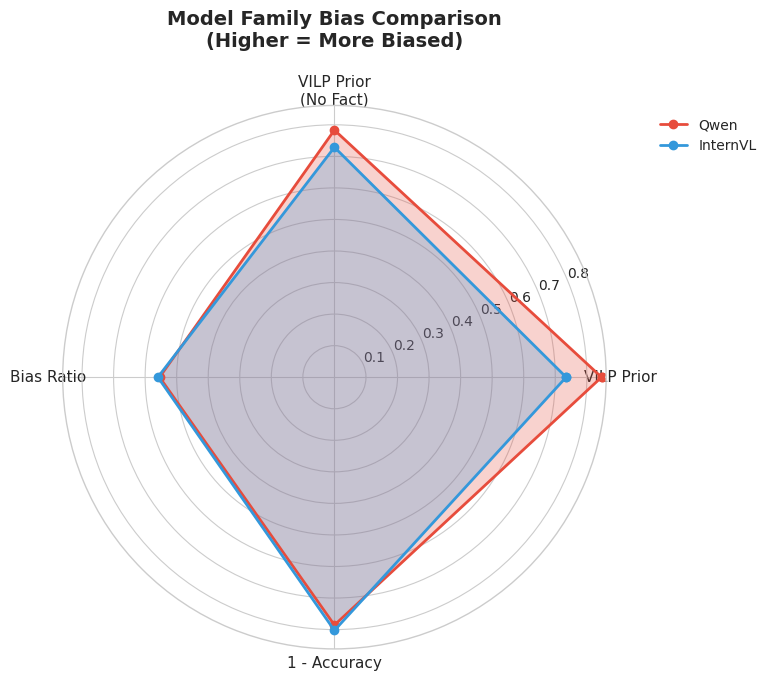

In [19]:
# Radar chart for model family comparison
from math import pi

# Prepare data for radar chart
categories = ['VILP Prior', 'VILP Prior\n(No Fact)', 'Bias Ratio', '1 - Accuracy']
N = len(categories)

# Calculate mean values for each family (normalize to 0-1 scale)
radar_data = {}
for family in ['Qwen', 'InternVL']:
    vals = []
    # VILP Prior (already 0-1)
    vals.append(df_vilp[df_vilp['model_family'] == family]['vilp_prior'].mean())
    # VILP Prior No Fact
    vals.append(df_vilp_nofact[df_vilp_nofact['model_family'] == family]['vilp_prior'].mean())
    # Bias Ratio
    vals.append(df_vlms_biased[df_vlms_biased['model_family'] == family]['bias_ratio'].mean())
    # 1 - Accuracy (to make higher = worse)
    vals.append(1 - df_vlms_biased[df_vlms_biased['model_family'] == family]['accuracy'].mean())
    radar_data[family] = vals

# Create radar chart
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Complete the loop

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for family, values in radar_data.items():
    values += values[:1]  # Complete the loop
    ax.plot(angles, values, 'o-', linewidth=2, label=family, 
            color=MODEL_FAMILY_COLORS.get(family, 'gray'))
    ax.fill(angles, values, alpha=0.25, color=MODEL_FAMILY_COLORS.get(family, 'gray'))

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11)
ax.set_title('Model Family Bias Comparison\n(Higher = More Biased)', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.savefig('family_radar_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Summary Table

In [20]:
# Create a comprehensive summary table
summary_data = []

models = df['model'].unique()
for model in models:
    row = {'Model': get_short_name(model)}
    
    # Get size
    model_data = df[df['model'] == model].iloc[0]
    row['Size (B)'] = model_data['model_size_b']
    row['Family'] = model_data['model_family']
    
    # VILP metrics
    vilp_row = df_vilp[df_vilp['model'] == model]
    if not vilp_row.empty:
        row['VILP Prior'] = f"{vilp_row['vilp_prior'].values[0]:.3f}"
        row['VILP Score'] = f"{vilp_row['vilp_score'].values[0]:.3f}"
    
    # VILP no fact metrics
    vilp_nf_row = df_vilp_nofact[df_vilp_nofact['model'] == model]
    if not vilp_nf_row.empty:
        row['VILP Prior (NF)'] = f"{vilp_nf_row['vilp_prior'].values[0]:.3f}"
    
    # VLMs Are Biased metrics
    vlms_row = df_vlms_biased[df_vlms_biased['model'] == model]
    if not vlms_row.empty:
        row['Accuracy'] = f"{vlms_row['accuracy'].values[0]:.3f}"
        row['Bias Ratio'] = f"{vlms_row['bias_ratio'].values[0]:.3f}"
    
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Size (B)')

print("=" * 80)
print("COMPLETE RESULTS SUMMARY (sorted by model size)")
print("=" * 80)
print(summary_df.to_string(index=False))
print("\nNF = No Fact variant")
print("Higher VILP Prior / Bias Ratio = More Biased")
print("Lower Accuracy = More Biased")

COMPLETE RESULTS SUMMARY (sorted by model size)
                 Model  Size (B)   Family VILP Prior VILP Score VILP Prior (NF) Accuracy Bias Ratio
          InternVL3-1B       1.0 InternVL      0.543      0.342           0.487    0.192      0.471
          InternVL3-2B       2.0 InternVL      0.650      0.592           0.707    0.240      0.539
Qwen2.5-VL-3B-Instruct       3.0     Qwen      0.820      0.542           0.740    0.199      0.513
Qwen2.5-VL-7B-Instruct       7.0     Qwen      0.873      0.547           0.827    0.230      0.596
          InternVL3-8B       8.0 InternVL      0.837      0.518           0.747    0.207      0.584
          InternVL3-9B       9.0 InternVL      0.717      0.423           0.770    0.200      0.513
         InternVL3-14B      14.0 InternVL      0.830      0.543           0.813    0.189      0.687
         InternVL3-38B      38.0 InternVL      0.830      0.573           0.850    0.157      0.564

NF = No Fact variant
Higher VILP Prior / Bias Ratio

In [21]:
# Save summary to CSV
summary_df.to_csv('bias_benchmark_summary.csv', index=False)
print("Summary saved to bias_benchmark_summary.csv")

Summary saved to bias_benchmark_summary.csv


## 8. Key Findings

### Inverse Scaling Laws Observed:
1. **VILP Prior**: Larger models show higher prior bias scores
2. **VLMs Are Biased**: Larger models tend to have higher bias ratios
3. **Accuracy Degradation**: Larger models show decreased accuracy on bias-probing tasks

### Notable Patterns:
- The InternVL3-38B model shows particularly low accuracy on the VLMs Are Biased benchmark
- Factual context tends to increase bias in larger models
- Topic-specific bias varies significantly, with "Chess Pieces" and "Animals" showing near-zero accuracy across all models